# 2.4.0 Creating a choropleth building permit density in Nashville

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd 
from shapely.geometry import Point

import folium 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
sys.path.append("../") 

from utils.paths import make_dir_line

modality = 'c'
project = 'Visualizing Geospatial Data in Python'
data = make_dir_line(modality, project)

raw = data('raw')
external = data("external")

## 2.4.2 Finding counts from a spatial join

In [4]:
permits = pd.read_csv(raw / "building_permits_2017.csv", sep=',')
print(permits.info())
permits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10795 entries, 0 to 10794
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   permit_id  10795 non-null  object 
 1   issued     10795 non-null  object 
 2   cost       10784 non-null  float64
 3   lat        10795 non-null  float64
 4   lng        10795 non-null  float64
dtypes: float64(3), object(2)
memory usage: 421.8+ KB
None


,permit_id,issued,cost,lat,lng
0,2017032777,2017-05-24,226201.0,36.198241,-86.742235
1,2017061156,2017-10-23,15000.0,36.151554,-86.830222
2,2017074521,2017-11-20,13389.0,36.034239,-86.708892
3,2017035041,2017-05-30,40000.0,36.128659,-86.841815
4,2017000049,2017-01-09,268107.0,36.045042,-86.616211


In [5]:
council_districts = gpd.read_file(external / "council_districts.geojson")
council_districts.head()

,first_name,email,res_phone,bus_phone,last_name,position,district,geometry
0,Nick,nick.leonardo@nashville.gov,615-509-6334,615-862-6780,Leonardo,Council Member,1,"MULTIPOLYGON (((-86.90738 36.39052, -86.90725 ..."
1,DeCosta,decosta.hastings@nashville.gov,615-779-1565,615-862-6780,Hastings,Council Member,2,"MULTIPOLYGON (((-86.75902 36.23091, -86.75909 ..."
2,Nancy,nancy.vanreece@nashville.gov,615-576-0488,615-862-6780,VanReece,Council Member,8,"MULTIPOLYGON (((-86.72850 36.28328, -86.72791 ..."
3,Bill,bill.pridemore@nashville.gov,615-915-1419,615-862-6780,Pridemore,Council Member,9,"MULTIPOLYGON (((-86.68681 36.28671, -86.68706 ..."
4,Robert,robert.swope@nashville.gov,615-308-0577,615-862-6780,Swope,Council Member,4,"MULTIPOLYGON (((-86.74489 36.05316, -86.74491 ..."


In [6]:
# Create a shapely Point from lat and lng
permits['geometry'] = permits.apply(lambda x: Point((x.lng , x.lat)), axis = 1)

In [7]:
# Build a GeoDataFrame: permits_geo
permits_geo = gpd.GeoDataFrame(permits, crs = council_districts.crs, geometry = permits.geometry)

In [8]:
# Spatial join of permits_geo and council_districts
permits_by_district = gpd.sjoin(permits_geo, council_districts, op = 'within')
print(permits_by_district.head(2))

     permit_id      issued      cost        lat        lng   
0   2017032777  2017-05-24  226201.0  36.198241 -86.742235  \
68  2017053890  2017-09-05       0.0  36.185442 -86.768239   

                      geometry  index_right first_name   
0   POINT (-86.74223 36.19824)            5      Scott  \
68  POINT (-86.76824 36.18544)            5      Scott   

                        email     res_phone     bus_phone last_name   
0   scott.davis@nashville.gov  615-554-9730  615-862-6780     Davis  \
68  scott.davis@nashville.gov  615-554-9730  615-862-6780     Davis   

          position district  
0   Council Member        5  
68  Council Member        5  


In [9]:
# Create permit_counts
permit_counts = permits_by_district.groupby(['district']).size()
print(permit_counts)

district
1     146
10    119
11    239
12    163
13    139
14    261
15    322
16    303
17    786
18    287
19    969
2     399
20    799
21    569
22    291
23    206
24    458
25    435
26    179
27    105
28    119
29    154
3     215
30     79
31    134
32    225
33    355
34    218
35    192
4     139
5     452
6     455
7     468
8     209
9     186
dtype: int64


## 2.4.3 Council district areas and permit counts

In [10]:
# Create an area column in council_districts
council_districts['area'] = council_districts.geometry.area
print(council_districts.head(2))

  first_name                           email     res_phone     bus_phone   
0       Nick     nick.leonardo@nashville.gov  615-509-6334  615-862-6780  \
1    DeCosta  decosta.hastings@nashville.gov  615-779-1565  615-862-6780   

  last_name        position district   
0  Leonardo  Council Member        1  \
1  Hastings  Council Member        2   

                                            geometry      area  
0  MULTIPOLYGON (((-86.90738 36.39052, -86.90725 ...  0.022786  
1  MULTIPOLYGON (((-86.75902 36.23091, -86.75909 ...  0.002927  


In [11]:
permits_df = permit_counts.to_frame()
print(permits_df.head(2))

            0
district     
1         146
10        119


In [12]:
# Reset index and column names
permits_df.reset_index(inplace=True)
permits_df.columns = ['district', 'bldg_permits']
print(permits_df.head(2))

  district  bldg_permits
0        1           146
1       10           119


In [13]:
# Merge council_districts and permits_df: 
districts_and_permits = pd.merge(council_districts, permits_df, on = 'district')
print(districts_and_permits.head(2))

  first_name                           email     res_phone     bus_phone   
0       Nick     nick.leonardo@nashville.gov  615-509-6334  615-862-6780  \
1    DeCosta  decosta.hastings@nashville.gov  615-779-1565  615-862-6780   

  last_name        position district   
0  Leonardo  Council Member        1  \
1  Hastings  Council Member        2   

                                            geometry      area  bldg_permits  
0  MULTIPOLYGON (((-86.90738 36.39052, -86.90725 ...  0.022786           146  
1  MULTIPOLYGON (((-86.75902 36.23091, -86.75909 ...  0.002927           399  


## 2.4.4 Calculating a normalized metric

In [14]:
print(type(districts_and_permits))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [15]:
# Create permit_density column in districts_and_permits
districts_and_permits['permit_density'] = districts_and_permits.apply(lambda row: row.bldg_permits / row.area, axis = 1)

# Print the head of districts_and_permits
print(districts_and_permits.head())

  first_name                           email     res_phone     bus_phone   
0       Nick     nick.leonardo@nashville.gov  615-509-6334  615-862-6780  \
1    DeCosta  decosta.hastings@nashville.gov  615-779-1565  615-862-6780   
2      Nancy    nancy.vanreece@nashville.gov  615-576-0488  615-862-6780   
3       Bill    bill.pridemore@nashville.gov  615-915-1419  615-862-6780   
4     Robert      robert.swope@nashville.gov  615-308-0577  615-862-6780   

   last_name        position district   
0   Leonardo  Council Member        1  \
1   Hastings  Council Member        2   
2   VanReece  Council Member        8   
3  Pridemore  Council Member        9   
4      Swope  Council Member        4   

                                            geometry      area  bldg_permits   
0  MULTIPOLYGON (((-86.90738 36.39052, -86.90725 ...  0.022786           146  \
1  MULTIPOLYGON (((-86.75902 36.23091, -86.75909 ...  0.002927           399   
2  MULTIPOLYGON (((-86.72850 36.28328, -86.72791 ...  0.

## 2.4.6 Geopandas choropleths

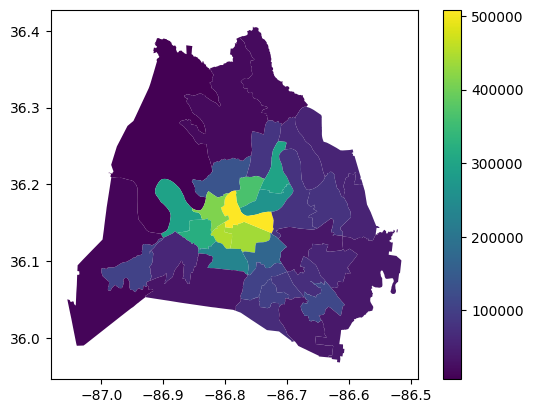

In [16]:
# Simple plot of building permit_density
districts_and_permits.plot(column = 'permit_density', legend = True);
plt.show();

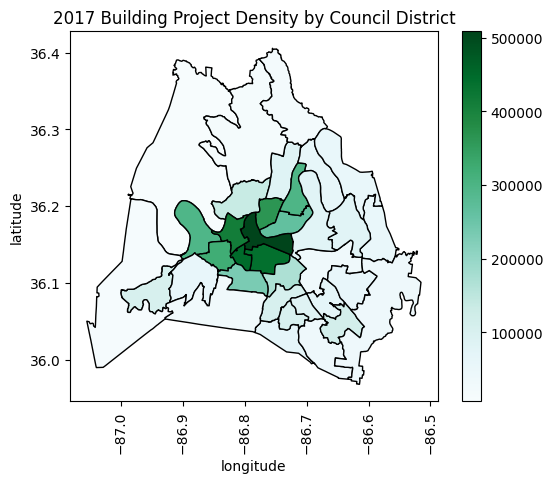

In [17]:
# Polished choropleth of building permit_density
districts_and_permits.plot(column = 'permit_density', cmap = 'BuGn', edgecolor = 'black', legend = True)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.xticks(rotation = 'vertical')
plt.title('2017 Building Project Density by Council District')
plt.show();

## 2.4.7 Area in km squared, geometry in decimal degrees

In [18]:
# Change council_districts crs to epsg 3857
council_districts = council_districts.to_crs(epsg = 3857)
print(council_districts.crs)
print(council_districts.head())

EPSG:3857
  first_name                           email     res_phone     bus_phone   
0       Nick     nick.leonardo@nashville.gov  615-509-6334  615-862-6780  \
1    DeCosta  decosta.hastings@nashville.gov  615-779-1565  615-862-6780   
2      Nancy    nancy.vanreece@nashville.gov  615-576-0488  615-862-6780   
3       Bill    bill.pridemore@nashville.gov  615-915-1419  615-862-6780   
4     Robert      robert.swope@nashville.gov  615-308-0577  615-862-6780   

   last_name        position district   
0   Leonardo  Council Member        1  \
1   Hastings  Council Member        2   
2   VanReece  Council Member        8   
3  Pridemore  Council Member        9   
4      Swope  Council Member        4   

                                            geometry      area  
0  MULTIPOLYGON (((-9674485.565 4354489.556, -967...  0.022786  
1  MULTIPOLYGON (((-9657970.373 4332440.650, -965...  0.002927  
2  MULTIPOLYGON (((-9654572.680 4339671.152, -965...  0.002517  
3  MULTIPOLYGON (((-964993

In [19]:
# Create area in square km
sqm_to_sqkm = 10**6
council_districts['area'] = council_districts.area / sqm_to_sqkm

# Change council_districts crs back to epsg 4326
council_districts = council_districts.to_crs(epsg = 4326)
print(council_districts.crs)
print(council_districts.head())

EPSG:4326
  first_name                           email     res_phone     bus_phone   
0       Nick     nick.leonardo@nashville.gov  615-509-6334  615-862-6780  \
1    DeCosta  decosta.hastings@nashville.gov  615-779-1565  615-862-6780   
2      Nancy    nancy.vanreece@nashville.gov  615-576-0488  615-862-6780   
3       Bill    bill.pridemore@nashville.gov  615-915-1419  615-862-6780   
4     Robert      robert.swope@nashville.gov  615-308-0577  615-862-6780   

   last_name        position district   
0   Leonardo  Council Member        1  \
1   Hastings  Council Member        2   
2   VanReece  Council Member        8   
3  Pridemore  Council Member        9   
4      Swope  Council Member        4   

                                            geometry        area  
0  MULTIPOLYGON (((-86.90738 36.39052, -86.90725 ...  350.194851  
1  MULTIPOLYGON (((-86.75902 36.23091, -86.75909 ...   44.956987  
2  MULTIPOLYGON (((-86.72850 36.28328, -86.72791 ...   38.667932  
3  MULTIPOLYGON ((

## 2.4.8 Spatially joining and getting counts

In [20]:
# Create permits_geo
permits_geo = gpd.GeoDataFrame(permits, crs = council_districts.crs, geometry = permits.geometry)
permits_geo.head()

,permit_id,issued,cost,lat,lng,geometry
0,2017032777,2017-05-24,226201.0,36.198241,-86.742235,POINT (-86.74223 36.19824)
1,2017061156,2017-10-23,15000.0,36.151554,-86.830222,POINT (-86.83022 36.15155)
2,2017074521,2017-11-20,13389.0,36.034239,-86.708892,POINT (-86.70889 36.03424)
3,2017035041,2017-05-30,40000.0,36.128659,-86.841815,POINT (-86.84181 36.12866)
4,2017000049,2017-01-09,268107.0,36.045042,-86.616211,POINT (-86.61621 36.04504)


In [21]:
# Spatially join permits_geo and council_districts
permits_by_district = gpd.sjoin(permits_geo, council_districts, op = 'within')
print(permits_by_district.head(2))

     permit_id      issued      cost        lat        lng   
0   2017032777  2017-05-24  226201.0  36.198241 -86.742235  \
68  2017053890  2017-09-05       0.0  36.185442 -86.768239   

                      geometry  index_right first_name   
0   POINT (-86.74223 36.19824)            5      Scott  \
68  POINT (-86.76824 36.18544)            5      Scott   

                        email     res_phone     bus_phone last_name   
0   scott.davis@nashville.gov  615-554-9730  615-862-6780     Davis  \
68  scott.davis@nashville.gov  615-554-9730  615-862-6780     Davis   

          position district       area  
0   Council Member        5  19.030612  
68  Council Member        5  19.030612  


In [22]:
# Count permits in each district
permit_counts = permits_by_district.groupby('district').size()

In [23]:
# Convert permit_counts to a df with 2 columns: district and bldg_permits
counts_df = permit_counts.to_frame()
counts_df = counts_df.reset_index()
counts_df.columns = ['district', 'bldg_permits']
print(counts_df.head(2))

  district  bldg_permits
0        1           146
1       10           119


## 2.4.9 Building a polished Geopandas choropleth

In [24]:
# Merge permits_by_district and counts_df
districts_and_permits = pd.merge(council_districts, counts_df, on = 'district')
print(districts_and_permits.head(2))

  first_name                           email     res_phone     bus_phone   
0       Nick     nick.leonardo@nashville.gov  615-509-6334  615-862-6780  \
1    DeCosta  decosta.hastings@nashville.gov  615-779-1565  615-862-6780   

  last_name        position district   
0  Leonardo  Council Member        1  \
1  Hastings  Council Member        2   

                                            geometry        area  bldg_permits  
0  MULTIPOLYGON (((-86.90738 36.39052, -86.90725 ...  350.194851           146  
1  MULTIPOLYGON (((-86.75902 36.23091, -86.75909 ...   44.956987           399  


In [25]:
# Create permit_density column
districts_and_permits['permit_density'] = districts_and_permits.apply(lambda row: row.bldg_permits / row.area, axis = 1)
print(districts_and_permits.head(2))

  first_name                           email     res_phone     bus_phone   
0       Nick     nick.leonardo@nashville.gov  615-509-6334  615-862-6780  \
1    DeCosta  decosta.hastings@nashville.gov  615-779-1565  615-862-6780   

  last_name        position district   
0  Leonardo  Council Member        1  \
1  Hastings  Council Member        2   

                                            geometry        area   
0  MULTIPOLYGON (((-86.90738 36.39052, -86.90725 ...  350.194851  \
1  MULTIPOLYGON (((-86.75902 36.23091, -86.75909 ...   44.956987   

   bldg_permits  permit_density  
0           146        0.416911  
1           399        8.875150  


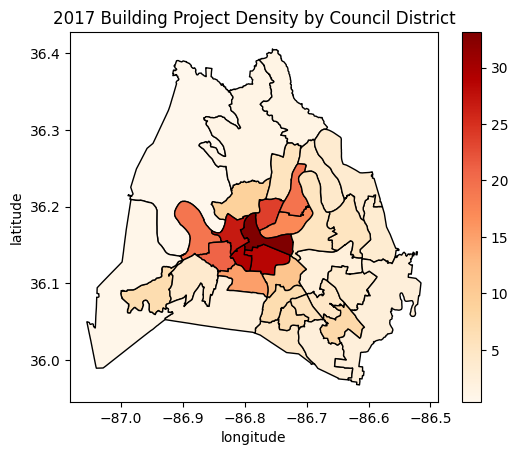

In [26]:
# Create choropleth plot
districts_and_permits.plot(column = 'permit_density', cmap = 'OrRd', edgecolor = 'black', legend = True)

# Add axis labels and title
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('2017 Building Project Density by Council District')
plt.show()

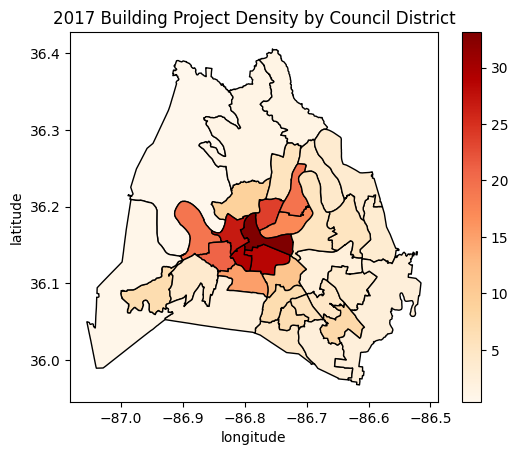

In [27]:
# Create choropleth plot
districts_and_permits.plot(column = 'permit_density', cmap = 'OrRd', edgecolor = 'black', legend = True)

# Add axis labels and title
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('2017 Building Project Density by Council District')
plt.show()

## 2.4.11 Folium choropleth

In [28]:
# Center point for Nashville
nashville = [36.1636,-86.7823]

# Create map
m = folium.Map(location=nashville, zoom_start=10)

folium.Choropleth(
    geo_data=districts_and_permits,
    name='geometry',
    data=districts_and_permits,
    columns=['district', 'permit_density'],
    key_on='feature.properties.district',
    fill_color='Reds',
    fill_opacity=0.5,
    line_opacity=1.0,
    legend_name='2017 Permitted Building Projects per km squared'
).add_to(m)

# Create LayerControl and add it to the map            
folium.LayerControl().add_to(m)

# Display the map
display(m)   

## 2.4.12 Folium choropleth with markers and popups

In [29]:
# Create center column for the centroid of each district
districts_and_permits['center'] = districts_and_permits.geometry.centroid

In [30]:
# Build markers and popups
for row in districts_and_permits.iterrows():
    row_values = row[1] 
    center_point = row_values['center']
    location = [center_point.y, center_point.x]
    popup = ('Council District: ' + str(row_values['district']) + 
             ';  ' + 'permits issued: ' + str(row_values['bldg_permits']))
    marker = folium.Marker(location = location, popup = popup)
    marker.add_to(m)
    
# Display the map
display(m)

In [31]:
print('Ok_')

Ok_
